# Data access

This notebook contains scripts to access the data and graphs for the investigated polar compounds.
Here, you can print out optimized cifs, RDF-plots and vibrational spectra.

First, install the necessary Python modules and load them. Please copy the whole database to the folder Database, so that it contains the folders "FE", "PE" and "WM". As an example, only the data of BaZnF4 is present, right now.

In [ ]:
%pip install pandas
%pip install matplotlib

In [1]:
import pandas as pd
import os

In [2]:
path = "./Database"

### Loading of compound list
Now, we load the compound info from the file "compounds.csv" that contains the formula and crystallographic information of all investigated compounds.

In [3]:
compounds = pd.read_csv(os.path.join("compounds.csv"))
compounds.columns

Index(['Unnamed: 0', 'crystal_class', 'compound', 'spacegroup', 'sg_nr',
       'pearson_sym', 'polar', 'category', 'folder'],
      dtype='object')

In [4]:
# Unique compounds
compounds["compound"].unique()

array(['CaCrF5', 'KY2F7', 'BaFeCuF7', 'CsYb3F10', 'Sr4Zn3F14',
       'Al3Pb5F19', 'LiFe2F6', 'KCoF3', 'Ba3Al2Cu2F16', 'K2Mn2Be3F12',
       'YZrF7', 'Rb2NaAl6F21', 'Na3FeF6', 'Na2TiF6', 'Mn3F8', 'Rb5Zr4F21',
       'Sr3Fe2F12', 'SrAlF5', 'Ba5In3F19', 'K2LiAlF6', 'PrZr3F15', 'MnF4',
       'CsTi8F33', 'CsPbF3', 'Rb2MnF6', 'UF3', 'Cs3Ga2F9', 'RbY3F10',
       'K3TaF8', 'NaSrAlF6', 'K2YF5', 'KFeF4', 'BaLi2Al2F10', 'NaMn3F10',
       'KNa2ZrF7', 'PtF4', 'K5ThF9', 'BeH8_NF2_2', 'KNaSnF6', 'Na2MgAlF7',
       'MnAlF5', 'TlF', 'K2BeF4', 'RbCrF5', 'RbTh3F13', 'K2FeF5',
       'HfPb2F8', 'Cs2AlF5', 'RbTlF4', 'Li3AlF6', 'BaZnF4', 'KLiBeF4',
       'Ba2AlCu2F11', 'Na2UF6', 'KTlF4', 'KYF4'], dtype=object)

### Definition of plotting functions
Next, we define all necessary functions for plotting.

In [5]:
def print_cif(compound: str,polar: bool =True):
    """
    Prints out the CIF-File of the DFT structure optimization.
    compound (str) : Compound-Formula
    polar (bool): select polar or centrosymmetric variant
    """
    folder = os.path.join(path,
                          compounds[(compounds["compound"]==compound) & (compounds["polar"]==polar)]["folder"].item()
                         )
    
    # Datei öffnen und lesen
    with open(os.path.join(folder,"opt/opt.cif"), "r", encoding="utf-8") as f:
        inhalt = f.read()

    print(inhalt)  # gibt den gesamten Inhalt in der Konsole aus


def print_vib(compound: str, polar: bool = True):

    from pathlib import Path
    
    folder = os.path.join(path,
                          compounds[(compounds["compound"]==compound) & (compounds["polar"]==polar)]["folder"].item(),
                          "spec"
                         )

    irspec = str(list(Path(folder).glob("*.irspec"))[0])
    ramspec = str(list(Path(folder).glob("*.ramspec"))[0])

        
    df_spec = prepare_spec_plot(irspec,ramspec)

    df_ir_modes = pd.read_csv(os.path.join(folder,"IR_modes.csv"))
    df_raman_modes = pd.read_csv(os.path.join(folder,"Raman_modes.csv"))

    df_raman_modes["I_tot"]=0.5*df_raman_modes["I_tot"]/df_raman_modes["I_tot"].max()
    df_ir_modes["Intensity"]=1-0.5*(df_ir_modes["Intensity"]/df_ir_modes["Intensity"].max())

    spec_plot(df_spec,df_ir_modes,df_raman_modes,compound)

def prepare_spec_plot(irspec,ramspec):
        
        import pandas as pd
        
                
        #Einlesen der Spektren
        df_ramspec = pd.read_csv(ramspec,dtype="float",sep="\s+",header=None)
        df_irspec = pd.read_csv(irspec,dtype="float",sep="\s+",header=None)
        
        #Modifizieren + Normalisieren der Spektren
        raman_dat=df_ramspec[[0,1]]
        raman_dat.columns=["wavenumber","raman_int"]
        ir_dat=df_irspec[[0,2]]
        ir_dat.columns=["wavenumber","ir_int"]
        
        df_spec = pd.concat([raman_dat,ir_dat["ir_int"]],axis=1)
        df_spec["raman_int"]=df_spec["raman_int"]/df_spec["raman_int"].max()
        df_spec["ir_int"]=1-df_spec["ir_int"]/df_spec["ir_int"].max()
        
        return df_spec

def spec_plot(df_spec,df_ir_modes,df_raman_modes,compound):
        
        import matplotlib as mpl
        import matplotlib.pyplot as plt
                
        #Global plot parameters
        plt.rcParams['font.family'] = "Arial"
        plt.rcParams['font.size'] = 12
        plt.rcParams['legend.frameon'] = False
        plt.rcParams['legend.fancybox'] = False
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams["figure.figsize"] = (6,5)
        plt.rcParams["figure.dpi"] = 300
        
        #Plot spectra
        fig= plt.figure()
        fig.suptitle(f"Vibrational spectra of {compound}", fontsize=14)
        gs = fig.add_gridspec(2, hspace=0,height_ratios=[1, 1])
        axs = gs.subplots(sharex=True, sharey=False)
        
        #X-Achse
        axs[0].set_xlim([df_spec["wavenumber"].max()-100,0]) 
        axs[0].tick_params(axis='x', which='both', direction='in', top=True)
        axs[0].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        axs[1].set_xlabel('Wavenumber / cm$^{-1}$')
        axs[1].tick_params(axis='x', which='both', direction='out', top=True)
        
        #Y-Achse
        axs[0].set_ylabel('Transmission / a.u.')
        axs[0].set_yticks([])
        
        axs[1].set_ylabel('Raman int. / a.u.')
        axs[1].set_yticks([])
        
        #Beschriftung
        axs[0].text(0.85, 0.2, 'a) IR', 
                transform=axs[0].transAxes,   # Position relativ zu Achsengröße
                fontsize=12,
                verticalalignment='top',
                horizontalalignment='left',
                fontweight='bold')
        axs[1].text(0.85, 0.9, 'b) Raman', 
                transform=axs[1].transAxes,   # Position relativ zu Achsengröße
                fontsize=12,
                verticalalignment='top',
                horizontalalignment='left',
                fontweight='bold')
        #Plots
        axs[0].plot(df_spec["wavenumber"],df_spec["ir_int"],color="black")
        axs[1].plot(df_spec["wavenumber"],df_spec["raman_int"],color="black")
        markerline, stemlines, baseline = axs[1].stem(df_raman_modes["Frequency_(cm-1)"],
                                                      df_raman_modes["I_tot"],
                                                      linefmt='-',
                                                      markerfmt=' ',
                                                      basefmt='',
                                                      bottom=0)
        markerline_ir, stemlines_ir, baseline_ir = axs[0].stem(df_ir_modes["Frequency_(cm-1)"],
                                                      df_ir_modes["Intensity"],
                                                      linefmt='-',
                                                      markerfmt=' ',
                                                      basefmt='',
                                                      bottom=1)
        
        plt.setp(stemlines, linewidth=1,color="red")
        plt.setp(baseline, linewidth=0,color="red")
        plt.setp(stemlines_ir, linewidth=1,color="red")
        plt.setp(baseline_ir, linewidth=0,color="red")
        #axs[0].legend(loc="upper center",bbox_to_anchor=(0.6,0.99))
        plt.tight_layout()
        plt.show()



def print_RDF(compound: str):

    category = compounds[(compounds["compound"]==compound) & (compounds["polar"]==True)]["category"].item()
    
    if category == "PE":
        print("RDF plots only available for category FE and WM.")
        return
    
    #Define RDF-File paths    
    folder_polar = os.path.join(path,
                                compounds[(compounds["compound"]==compound) & (compounds["polar"]==True)]["folder"].item()
                         )
    folder_centro = os.path.join(path,
                                compounds[(compounds["compound"]==compound) & (compounds["polar"]==False)]["folder"].item()
                         )
    file_polar = os.path.join(folder_polar,"opt/rdf.dat")
    file_centro = os.path.join(folder_centro,"opt/rdf.dat")

    #Load RDF data
    data = format_rdf_data(file_polar,file_centro)
    
    #Get spacegroup symbols
    polar_sg = compounds[(compounds["compound"]==compound) & (compounds["polar"]==True)]["spacegroup"].item()
    centro_sg = compounds[(compounds["compound"]==compound) & (compounds["polar"]==False)]["spacegroup"].item()

    
    plot_rdf(data,polar_sg,centro_sg,compound)
    
def plot_rdf(dataframe,polar_sg,para_sg,compound):

        import matplotlib as mpl
        import matplotlib.pyplot as plt
        
        # Define variables
        data = dataframe
        polar_sym = transform_spacegroup_symbol(polar_sg)
        para_sym = transform_spacegroup_symbol(para_sg)
        
        #Globale Plot-Optionen
        plt.rcParams['font.family'] = "Arial"
        plt.rcParams['font.size'] = 12
        plt.rcParams['legend.frameon'] = False
        plt.rcParams['legend.fancybox'] = False
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams["figure.figsize"] = (6,4)
        plt.rcParams["figure.dpi"] = 300
       
        #Set figure
        fig= plt.figure()
        fig.suptitle(f"RDF of {compound}", fontsize=14)
        gs = fig.add_gridspec(2, hspace=0,height_ratios=[3, 1])
        axs = gs.subplots(sharex=True, sharey=False)
        
        #X-Achse
        axs[0].set_xlim([1,8]) 
        axs[0].tick_params(axis='x', which='both', direction='in', top=True)
        axs[0].xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
        axs[1].set_xlabel('Atomic distance / $\AA$')
        axs[1].tick_params(axis='x', which='both', direction='in', top=True)
        
        #Y-Achse
        axs[0].set_ylabel('$\mathregular{RDF_{tot}}$')
        axs[0].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        axs[0].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        axs[1].set_ylabel('$\Delta\mathregular{RDF_{tot}}$')
        axs[1].set_ylim([-1.5,1.5])
        axs[1].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1f'))
        axs[1].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        
        #Plots
        axs[0].plot(data["r_ang"],data["rdf"],color="black", label=polar_sym)
        axs[0].plot(data["r_ang"],data["rdf_sg"],color="red", label=para_sym)
        axs[1].plot(data["r_ang"],data["rdf_sg"]-data["rdf"],color="grey", label='Diff')
        
        axs[0].legend(loc="upper center",bbox_to_anchor=(0.6,0.99))
        plt.tight_layout()
        plt.show()

def format_rdf_data(file_polar,file_para):
        
        import pandas as pd
        df_polar = pd.read_csv(file_polar,dtype="float",sep="\s+",skiprows=1,header=None)
        df_para = pd.read_csv(file_para,dtype="float",sep="\s+",skiprows=1,header=None)
        df_polar.columns = ["r_ang", "rdf"]
        df_para.columns = ["r_ang", "rdf_sg"]
        data = pd.concat([df_polar,df_para["rdf_sg"]],axis=1)
        return data
        
def transform_spacegroup_symbol(string):
       import re
       # Zwei aufeinander folgende Ziffern mit einem Unterstrich trennen
       transformed_string = re.sub(r'(\d)(\d)', r'\1_\2', string)
       transformed_string = re.sub(r'-(\d)', r'\\overline{\1}',transformed_string)
       #  Den String mit "$" beginnen und enden lassen
       transformed_string = f"${transformed_string}$"
       
       return transformed_string    

### Example of cif output

Use the function print_cif() to output the optimized CIF file of a specific compound. Input the formula as in the compounds.csv and as a boolian if you want the polar or the centrosymmetric modification.

In [7]:
print_cif("BaZnF4",polar=True)

# generated using pymatgen
data_BaZnF4
_symmetry_space_group_name_H-M   Cmc2_1
_cell_length_a   4.20580342
_cell_length_b   14.57194271
_cell_length_c   5.86497952
_cell_angle_alpha   90.00000000
_cell_angle_beta   90.00000000
_cell_angle_gamma   90.00000000
_symmetry_Int_Tables_number   36
_chemical_formula_structural   BaZnF4
_chemical_formula_sum   'Ba4 Zn4 F16'
_cell_volume   359.44539595
_cell_formula_units_Z   4
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
  2  '-x, -y, z+1/2'
  3  '-x, y, z'
  4  'x, -y, z+1/2'
  5  'x+1/2, y+1/2, z'
  6  '-x+1/2, -y+1/2, z+1/2'
  7  '-x+1/2, y+1/2, z'
  8  'x+1/2, -y+1/2, z+1/2'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Ba  Ba1  4  0.00000000  0.14857005  0.86728475  1
  Zn  Zn1  4  0.00000000  0.41327685  0.82687931  1
  F  F2  4  0.00000000  0.07651419  0.31156435  1
  F  F3  4  0.0000000

### Example of RDF plots

To plot the RDF functions of a polar/centrosymmetric structure pair, simply use the print_RDF() function specifying the formula of the compound.

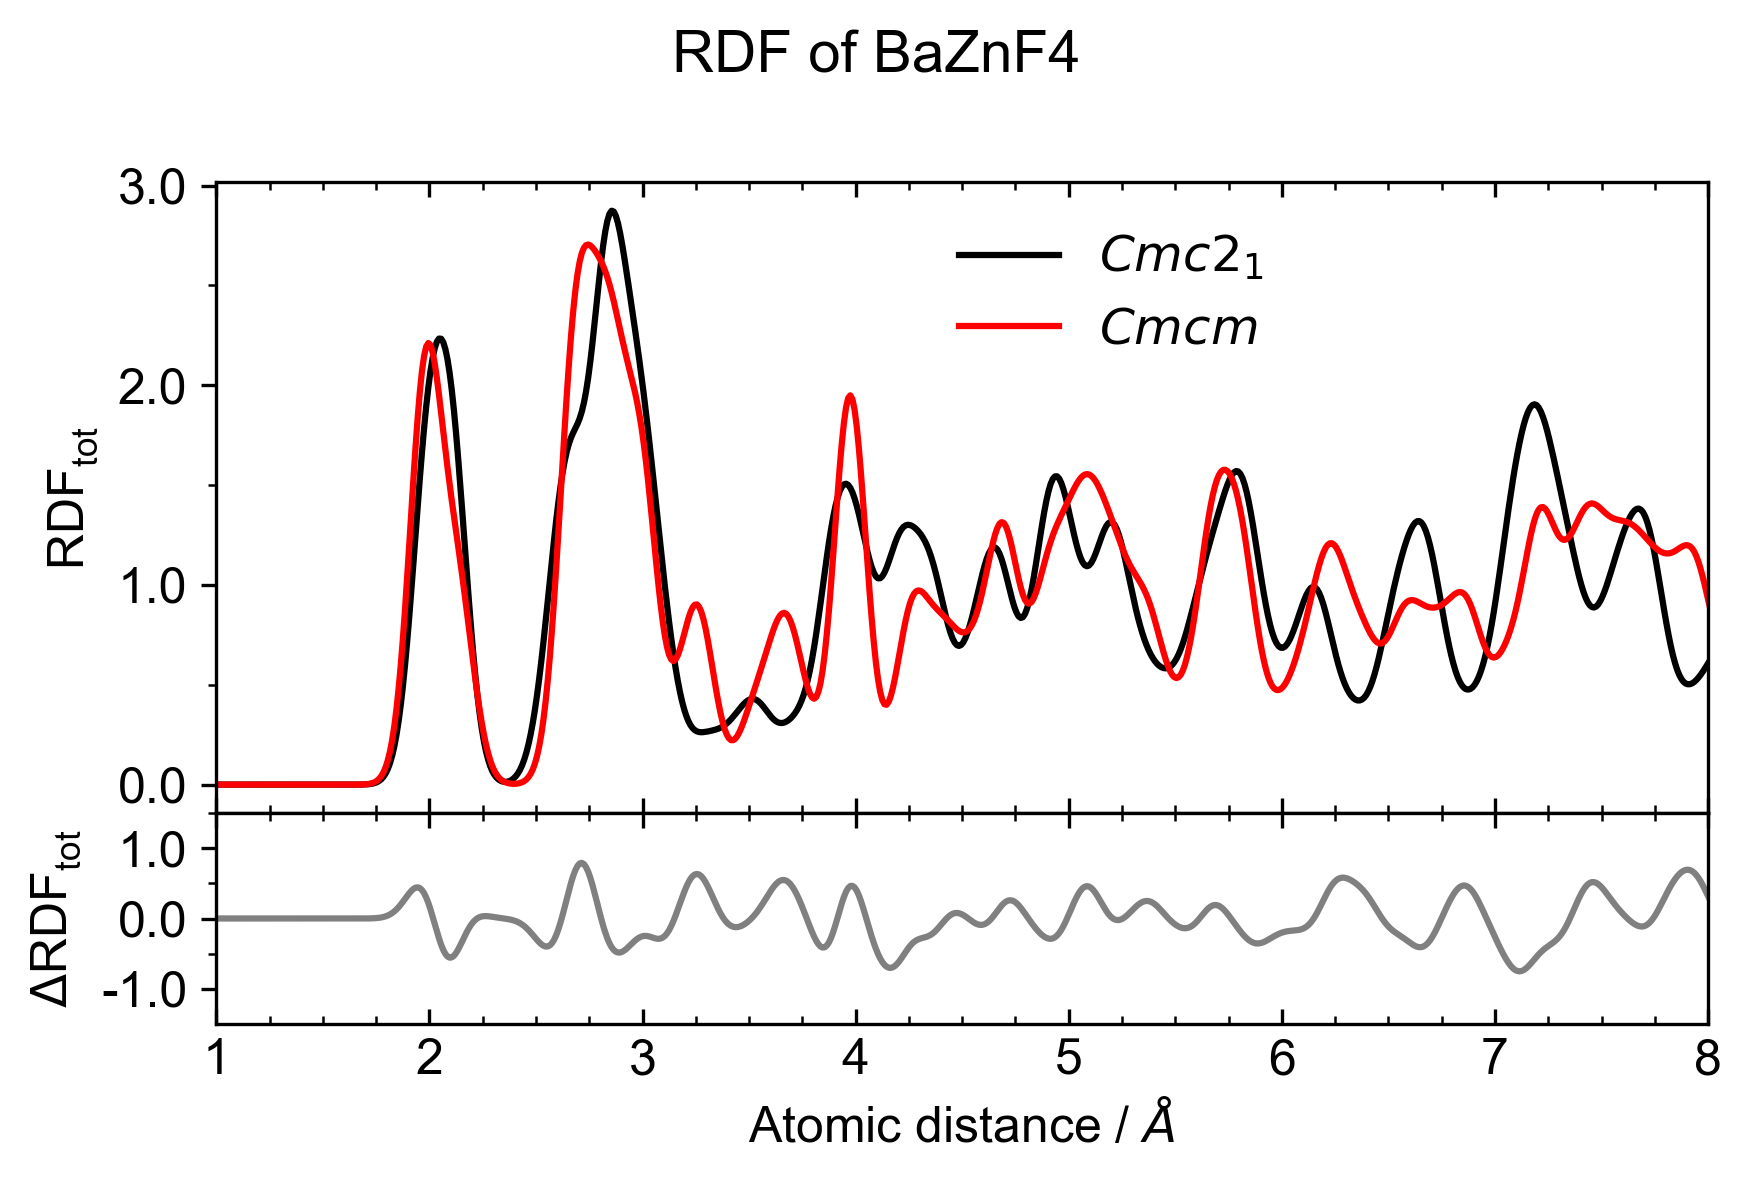

In [8]:
print_RDF("BaZnF4")

### Example of vibrational spectra plot

For plotting the vibrational spectra of a compound use the print_vib() function, again specifying the compound formula and if you want the polar or centrosymmetric variant.

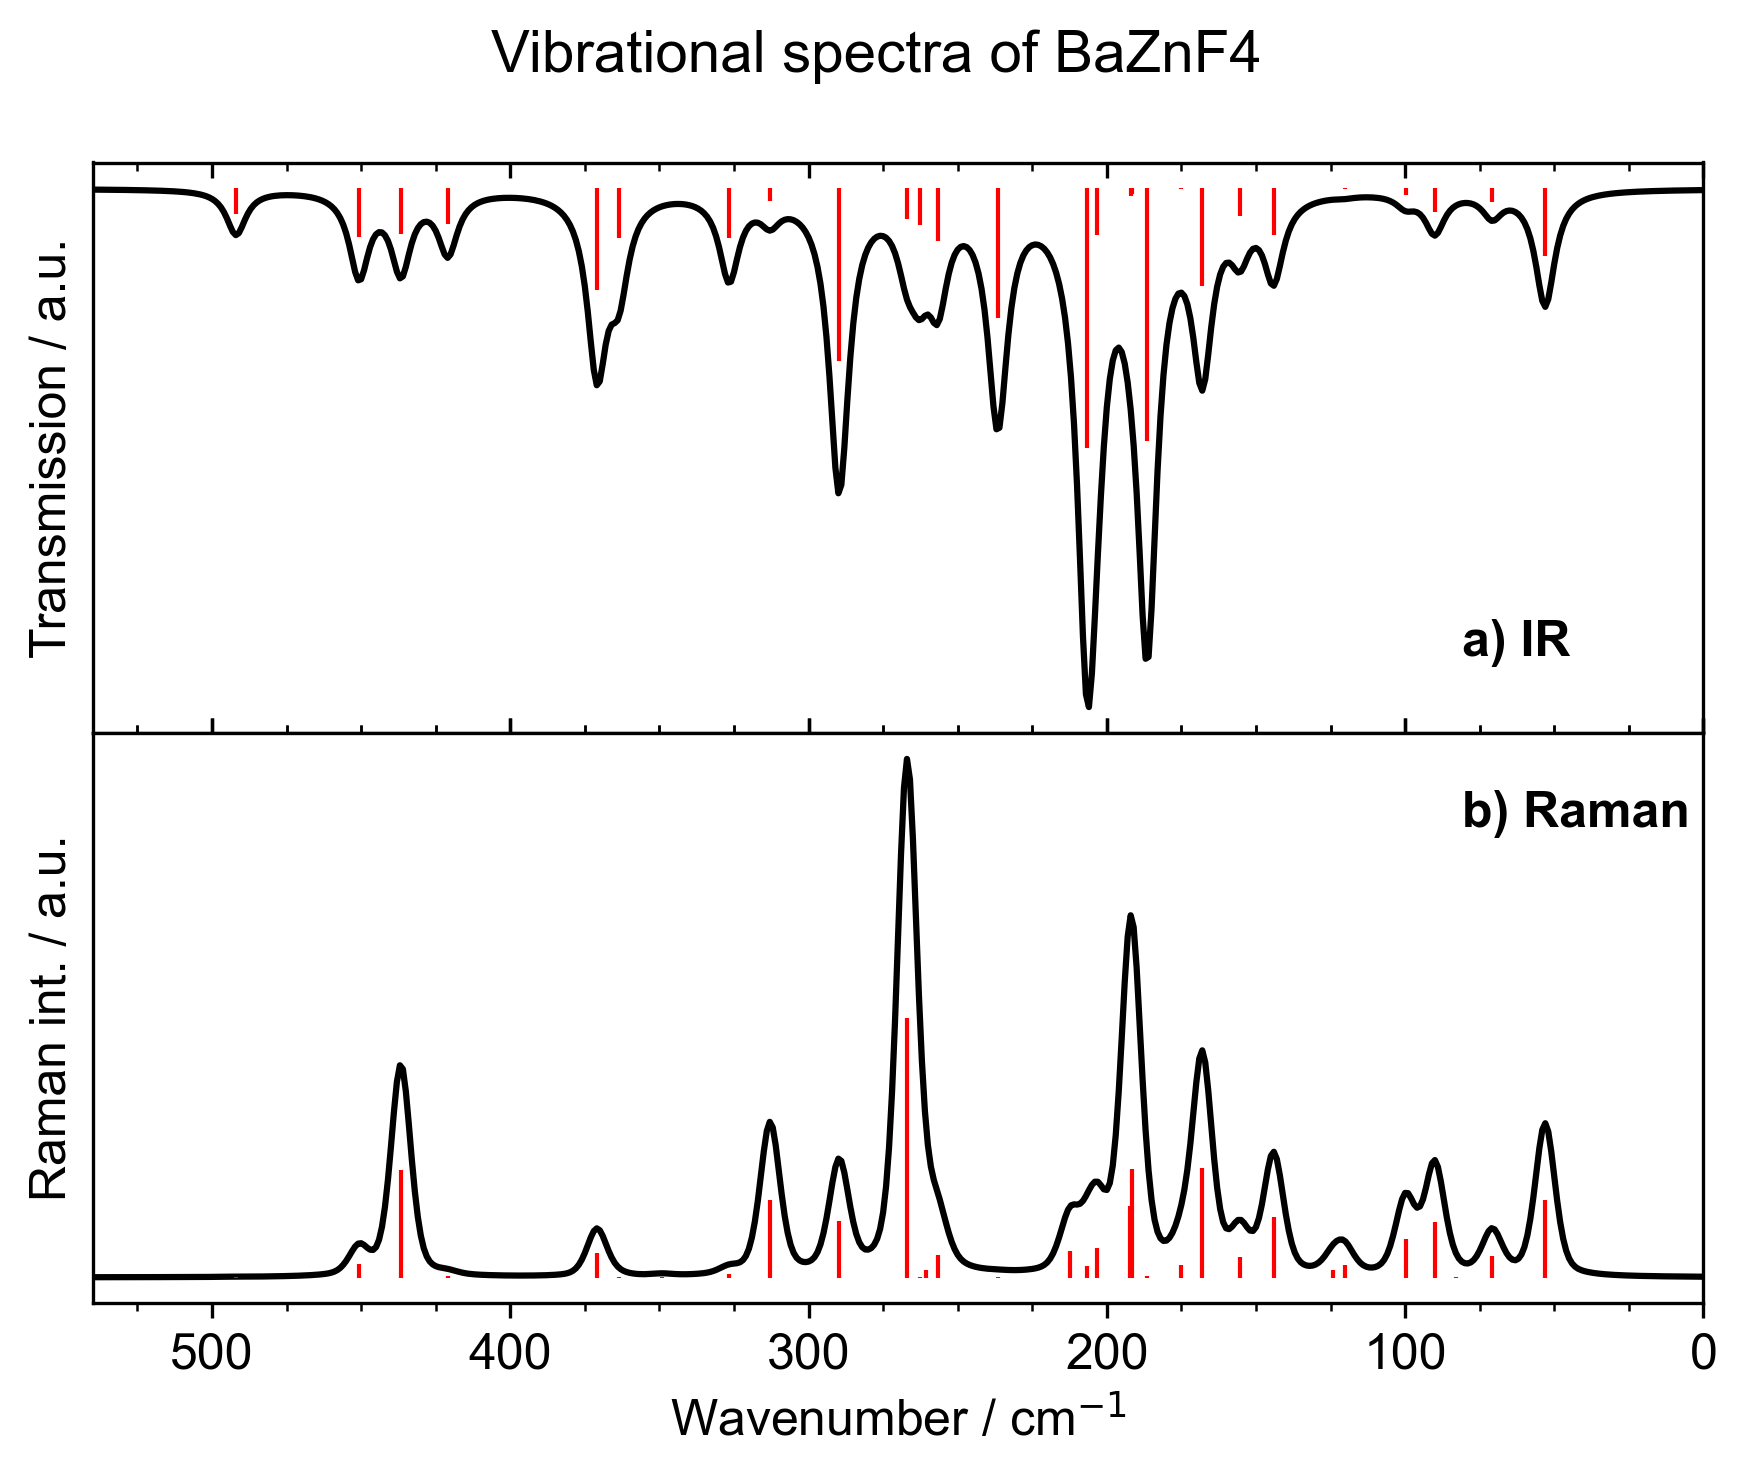

In [9]:
print_vib("BaZnF4",polar=True)